# Computing Climate Trends

## Introduction

We have many high-quality global climate datasets with a lon historic record of various climatic variables. Using cloud-hosted datasets and XArray, we can compute pixel-wise long-term trends for the climate variable of interest. This analysis helps us identify hotspots experienceing extreme climate change.

## Overview of the Task

We will be using the [TerraClimate](https://www.climatologylab.org/terraclimate.html) gridded dataset of monthly climate and climatic water balance at high spatial resolution (~4km grid size) with a long time-series (1958-current). We will extract a time-series of monthly maximum temperatures and compute per-pixel linear trend. The data is processed in distributed manner using Dask and the results are saved as a GeoTIFF file.

**Input Layers**:
*   `agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc`: Cloud-hosted NetCDF file for each climate variable.

**Output**:

* `tmax_slope.tif`: A GeoTIFF file with slope of trend at each pixel for the chosen region.
* `tmax_yearly_subset.nc`: A NetCDF file of yearly aggregated subset for the chosen region.

**Data Credit**:
*   Abatzoglou, J.T., S.Z. Dobrowski, S.A. Parks, K.C. Hegewisch, 2018, Terraclimate, a high-resolution global dataset of monthly climate and climatic water balance from 1958-2015, Scientific Data 5:170191, doi:10.1038/sdata.2017.191
* Runfola, D. et al. (2020) geoBoundaries: A global database of political administrative boundaries. PLoS ONE 15(4): e0231866. https://doi.org/10.1371/journal.pone.0231866




## Setup and Data Download

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install geopandas rioxarray cartopy dask[distributed] netCDF4

In [ ]:
import cartopy
import cartopy.crs as ccrs
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import dask

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Selecting a Region of Interest

[GeoBondaries](https://www.geoboundaries.org/) is an open databse of political administrative boundaries at different administrative levels. We download the Admin1 Boundaries.

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print(f'Downloaded {filename}')
    else:
        print(f'File {filename} exists.')

admin_boundaries = 'geoBoundariesCGAZ_ADM1.gpkg'

geoboundaries_url = 'https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/'
download(geoboundaries_url + admin_boundaries)


In [ ]:
admin_boundaries_filepath = os.path.join(data_folder, admin_boundaries)
admin_gdf = gpd.read_file(admin_boundaries_filepath, encoding='utf-8')

Select the country by its [3-letter ISO code](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3). Here we use the code GHA for Ghana.

In [ ]:
country = 'GHA'
country_gdf = admin_gdf[admin_gdf['shapeGroup'] == country]
country_gdf

Select a region. We select the *Greater Accra Region*.

In [ ]:
region_gdf = country_gdf[country_gdf['shapeName'] == 'Greater Accra Region']
region_gdf

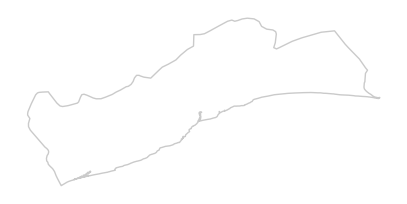

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
region_gdf.plot(
    ax=ax,
    edgecolor='#969696',
    facecolor='none',
    alpha=0.5)
ax.set_axis_off()
plt.show()

Get the bounding box to filter the XArray dataset.

In [ ]:
bounds = region_gdf.total_bounds
lon_min, lat_min, lon_max, lat_max = bounds

## Local Compute Cluster

Setup a Local Dask Cluster. This will enable parallel computing on your computer using available CPU cores.

In [ ]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

## Calculate Yearly Time-Series

TerraClimate large dataset that is hosted on a [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/tds/) and served using the [OPeNDAP](https://www.opendap.org/) (Open Data Access Protocol) protocol. XArray has built-in support to efficiently read and process OPeNDAP data where we can stream and process only the required pixels without downloading entire dataset.

We want to analyze the long-term yearly trend of monthly maximum temperatures.
Since the input data comes as monthly values, we first aggregate the data to yearly time steps.

In [ ]:
terraclimate_url = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'
variable = 'tmax'
filename = f'agg_terraclimate_{variable}_1958_CurrentYear_GLOBE.nc'

remote_file_path = os.path.join(terraclimate_url, filename)
ds = xr.open_dataset(
    remote_file_path,
    chunks='auto',
    engine='netcdf4',
)
ds

In [ ]:
# Select the variable
da = ds.tmax

# Select data within the bounding box

# Make sure the data is sorted for slice() to work correctly
da = da.sortby([da.lon, da.lat])

# Add 0.1 degree buffer
da_subset = da.sel(
    lon=slice(lon_min - 0.1, lon_max + 0.1),
    lat=slice(lat_min - 0.1, lat_max + 0.1)
)
da_subset

Aggregate the data to yearly means.

In [ ]:
da_yearly = da_subset.groupby('time.year').mean('time')
da_yearly

Process and load the data into memory. This may take a few minutes. Check the Dask dashboard to see the progress

> Note: The dask dashboard is not available on Colab.

In [ ]:
%%time
da_yearly = da_yearly.compute()

Plot a time-series at a single location to see the trend.

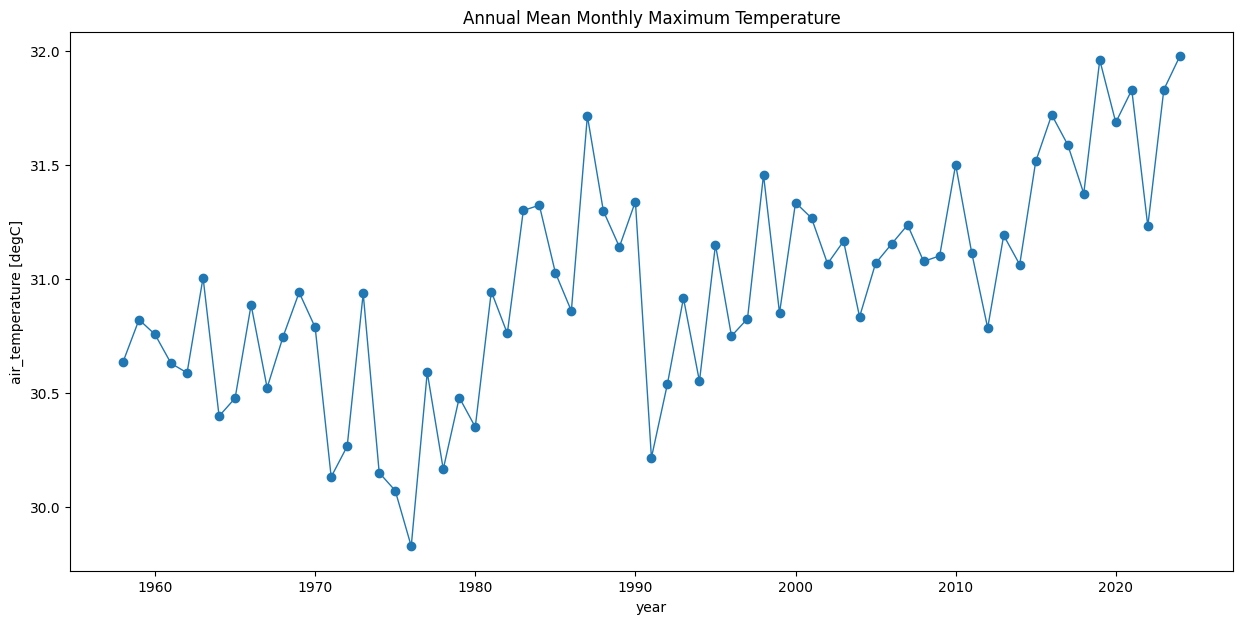

In [ ]:
# Choose a location within the region for plots
location = (5.65, -0.20) # Accra

time_series = da_yearly.interp(lat=location[0], lon=location[1])

fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='year', marker='o', linestyle='-', linewidth=1)
ax.set_title('Annual Mean Monthly Maximum Temperature')
plt.show()

## Compute the Trend

We can fit a polynomial at each pixel of the DataArray using the [`xarray.DataArray.polyfit`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.polyfit.html) method. Here we fit a linear trendline. As out input dataset has yearly time steps, the slope of the fitted trendline will be degrees per year. To make the trend more interpretable, we multiply it by 100 to get the results in the unit degrees per century.

In [ ]:
trend = da_yearly.polyfit('year', 1) # fit polynomial of degree 1
slope = trend.polyfit_coefficients[0,...] * 100 # per year -> per century

Visualize the slope of trendline.

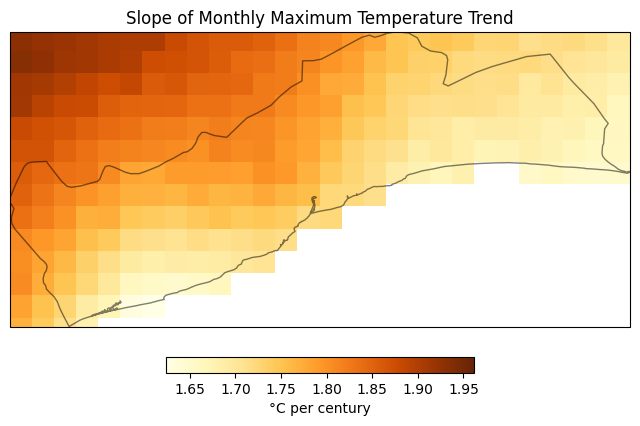

In [ ]:
projection = ccrs.PlateCarree()

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither',
    'label': '°C per century'
}

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
fig.set_size_inches(8, 8)
slope.plot.imshow(
    ax=ax,
    cmap='YlOrBr',
    transform=ccrs.PlateCarree(),
    add_labels=False,
    cbar_kwargs=cbar_kwargs)

region_gdf.plot(
    ax=ax,
    edgecolor='#000000',
    facecolor='none',
    alpha=0.5)

ax.set_extent((lon_min,lon_max,lat_min,lat_max), crs = ccrs.PlateCarree())

plt.title(f'Slope of Monthly Maximum Temperature Trend', fontsize = 12)
plt.show()

Save the resulting slope raster as a GeoTIFF.

In [ ]:
# Assign a CRS to the DataArray
slope.rio.write_crs('EPSG:4326', inplace=True)
# Clip to the GeoDataFrame coundary
clipped = slope.rio.clip(region_gdf.geometry.values)
# Write the file
output_slope_file = f'{variable}_slope.tif'
output_slope_path = os.path.join(output_folder, output_slope_file)
if not os.path.exists(output_slope_path):
    clipped.rio.to_raster(output_slope_path)
    print('Saved the file at ', output_slope_path)

We can also save the yearly aggregated subset as a NetCDF for other downstream analysis.

In [ ]:
local_subset_file = f'{variable}_yearly_subset.nc'
local_subset_filepath = os.path.join(output_folder, local_subset_file)
if not os.path.exists(local_subset_filepath):
    da_yearly.to_netcdf(path=local_subset_filepath)
    print('Saved the file at ', local_subset_filepath)

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>